In [2]:

import matplotlib.pyplot as plt
import math as mat
import numpy as np
from numpy import polynomial
from numpy.random import *
from scipy.misc import *
from scipy.stats import kstest
from scipy.special import factorial
from scipy import optimize
from scipy import stats
     

# **$\rm I)$ Générateurs pseudo-aléatoires**

Un générateur de nombres pseudo-aléatoires, est un algorithme qui génère une séquence de nombres présentant certaines propriétés du hasard. Par exemple, les nombres sont supposés être suffisamment indépendants les uns des autres, et il est potentiellement difficile de repérer des groupes de nombres qui suivent une certaine règle (comportements de groupe).

Un algorithme déterministe génère des suites de nombres qui ne peuvent pas satisfaire complètement les critères mathématiques qualifiant les suites aléatoires. On les appelle suites pseudo-aléatoires, car leurs propriétés s'approchent seulement des propriétés idéales des suites aléatoires parfaites. Comme le faisait remarquer ironiquement John von Neumann : 

*« Quiconque considère des méthodes arithmétiques pour produire des nombres aléatoires »* disait-il *« est, bien sûr, en train de commettre un péché »*.

Un générateur pseudo-aléatoire est un algorithme qui à partir d'un certain nombre (la graine) et d'un entier , génère une suite de nombres de longueur 
vérifiant certaines propriétés statistiques rendant sa structure difficilement identifiable. La suite produite est déterministe puisqu'elle est générée par un algorithme : à longueur et graine fixées, l'algorithme génèrera toujours la même suite de nombres. On parle donc de générateurs pseudo-aléatoires.

La qualité d'une suite pseudo-aléatoire dépend de ses propriétés statistiques, on évalue donc cette suite avec des théorèmes et des outils statistiques comme par exemple la **loi de grands nombres** ou les **tests d'adéquation**.

Dans cette première partie, nous allons générer de nombres pseudo-aléatoires entre 0 et 1. Les générateurs uniformes nous permettent de construire ensuite tous les générateurs de loi de probabilités usuelles. Nous allons illustrer à l'aide de différents générateurs pseudo-aléatoires les biais et limites empêchant la génération d'une suite parfaitement aléatoire.

Les algorithmes de géneration que nous avons implémenté ont une même structure:

- ils nécessitent un nombre initial nommé la graine.
- les nombres qui suivent sont définis par une relation de récurrence. 

## I.0 ) Évaluer un algorithme 

Pour évaluer un algorithme, nous utilisons certaines propriètés statistiques de la loi uniforme sur $[0,1]$ :

* Loi des grands nombres : la moyenne empirique doit tendre vers $ \frac{1}{2} $
 
* Test de Kolmogorov Smirnov : la fonction de répartiton empirique doit être "proche" de la fonction de répartition théorique. 

* Algorithme de FLoyd (algorithme du lièvre et de la tortue) : la liste des nombres générés ne doit pas comporter de périodes, c'est à dire une certaine succesion de nombres qui se répèteraient. 

**Loi forte des grands nombres**

In [20]:
# Loi des grands nombres 

def LGN(X):
    return np.abs(np.mean(X) - 0.5)

**Test de Kolmogorov Smirnov**

Données : $n$ observations d'une variable aléatoire $X$, $q$ observations d'une variable aléatoire $Y$.

Hypothèse testée : "Les fonctions de répartition de $X$ et de $Y$ sont égales" avec risque d'erreur $a$.

Calcul de la fonction de répartition : 

- On ordonne les valeurs observées $x_1\leq x_2\leq\cdots\leq x_n$.
- On considère la fonction de répartition empirique $F$ définie par 
$ f(x) = \begin{cases}
        0, & \text{si } x < x_1 \\
        \frac{1}{n}, & \text{si } x_1 \le x \le x_2 \\
        ... \\
        \frac{i}{n}, & \text{si } x_i \le x \le x_{i+1} \\
        1, & \text{si } x > x_n
    \end{cases} $

On calcule $ K=\sup |F_X(x)-F_Y(x)| $ et on compare avec la valeur critique de la loi du $\delta$ de Kolmogorov-Smirnov : si b est tel que $P (\delta > b) = a$ et si $ K < \sqrt{ \frac{p + q}{ pq }} b$ alors on accepte l'hypothèse, sinon on la rejette.

Condition de validité : $p$ et $q$ grands car on approxime la loi de $ | F_X - F_Y | $ par la loi limite. 

Ce test repose sur deux théorèmes, le **théorème de Glivenko Cantelli** et le **théorème de Kolmorov**. 

Soit $(X_{n})_{n}$ une suite de variables aléatoires *iid* de f.d.r. $F$ ($F$ est inconnue et on cherche à déterminer si $F=F_{ref}$. On note $F_{n}$ la fonction de répartition empirique, le théorème de Glivenko Cantelli nous assure que $D_{n} :=||F_{n} -F||_{∞}$ converge presque sûrement vers $0$. $F_{n}$ est donc un estimateur satisfaisant de $F$. De plus, le théorème de Kolmogorov assure que si $F$ est continue alors la loi de $D_{n}$ ne depend pas de $F$. Ce résultat  est très pratique puisqu'il rend la variable $D_{n}$ universelle, un test basé sur $D_{n}$ sera valable pour n'importe quelle variable aléatoire dont la fonction de  répartition est continue. La loi $D_{n}$ est tabulée, on note $d_{n,\alpha}$ son quantile d'ordre $\alpha$. Le test de Kolmogorov Smirnov de niveau $\alpha$, sous l'hypothèse nulle $F=F_{ref}$, est :


$\phi:=1_{D_{n}>d_{n,1-\alpha}}$ avec cette fois ci $D_{n} :=||F_{n} -F_{ref}||_{∞}$, $F$ étant inconnue.  


Le calcul pratique de $D_{n}$ est facilité par la formule suivante:
$D_n = \max_{1 \leq i \leq n} \max \left\{ \frac{i}{n} - F(X_{(i)}), \, F(X_{(i)}) - \frac{i-1}{n}\right\}.$ où les $(X_{(i)})_{i}$ sont supposés ordonnés.

In [82]:
# On commence par définir Dn 
def Dn(X, Fref):
    X_sorted = np.sort(X)
    n = len(X)
    max_left = [max( 
                    i / float(n) -  Fref(X_sorted[i-1]) , 
                    Fref(X_sorted[i-1]) - (i-1) / float(n)  
                    ) 
                for i in list(range(1 , n+1))]
    return max(max_left)

#test de Kolmogorov
#les quantiles sont tabulés, on importe la table des quantiles avec scipy.stats:
from scipy.stats import ksone

def dn_value(alpha,n):
    return ksone.ppf(1 - alpha, n)  #quantile d'ordre 1-alpha pour un certain n

def test_kolmogorov(X,Fref,alpha):
    if Dn(X,Fref)>dn_value(alpha,len(X)):
      return "l'échantillon ne suit pas la loi de réfèrence"
    return "l'échantillon suit la loi de réfèrence"

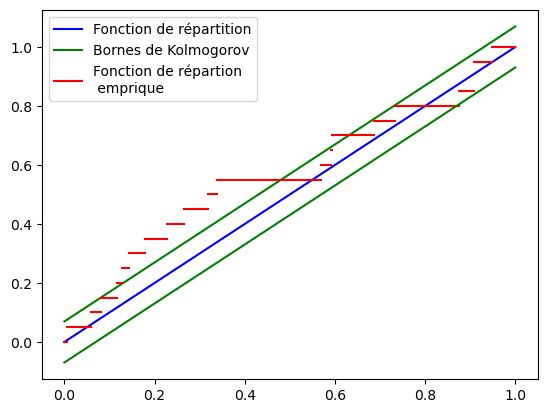

test de kolmogorov smirnov: L'échantillon ne suit pas la loi de réfèrence


In [8]:
n = 20
d = dn_value(0.05,n)

# Fonction de répartition
xx = np.linspace(0,1,101)
plt.plot(xx,xx,'b')

#borne sup de kolmogorov
plt.plot(xx,xx+d,'g')


#Fonction de répartition empirique
U = rand(n)
X = np.sort(U)
plt.plot([0,X[0]],[0,0],'r-')
for i in range(1,n):
    plt.plot([X[i-1],X[i]],[i/float(n),i/float(n)],'r-') 
plt.plot([X[-1],1],[1,1],'r-')

#borne inf de kolmogorov
plt.plot(xx,xx-d,'g')
plt.legend(["Fonction de répartition", "Bornes de Kolmogorov","Fonction de répartion \n emprique"])
plt.show()

#si la fdr empirique  est bien entre les deux droites vertes on peut affirmer que F=Fref.
print("test de kolmogorov smirnov:",test_kolmogorov(U, lambda x:x,0.05))

**Algorithme de Floyd**  

L'algorithme de Floyd (ou du lièvre et de la tortue) permet de détecter des cycles dans une liste de nombres $(x_{k})_{k}$. Cet algorithme repose sur le fait que si la liste admet un cycle, il existe un indice $j$ tel que $x_{j} = x_{2j}$. On parcourt donc la liste à deux vitesses, la tortue à une vitesse $1$ et le lièvre à une vitesse $2$. Ainsi le lièvre va commencer par parcourir $x_{2},x_{4}, x_{6}, x_{8}$ alors que la tortue parcourira $x_{1}, x_{2}, x_{3}, x_{4}$. Comparer le lièvre et la tortue nous permet de comparer les couples $(x_{k},x_{2k})$ et donc de trouver le cycle.

In [10]:
def Floyd(f, x0):
    m = 0 
    tortue = f(x0)
    lievre = f(tortue)
    while tortue!=lievre and m < 10**5:
        m += 1
        tortue = f(tortue)  #vitesse1
        lievre = f(f(lievre))  #vitesse2
    
    if m == 10**5: 
        return "pas de cycle trouvé"
    
    return "présence d'un cycle"   

## I-1 ) Générateur de nombres pseudos-aléatoires : algorithme de Von Neuman

En 1946, John von Neumann propose un générateur pseudo-aléatoire connu sous le nom de la méthode middle-square (carré médian). Très simple, elle consiste à prendre un nombre, à l'élever au carré et à prendre les chiffres au milieu comme sortie.

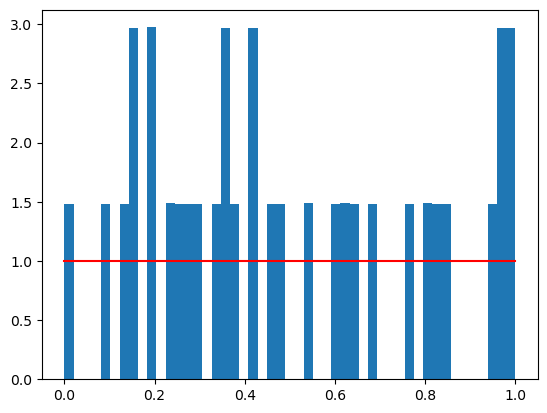

In [22]:
def f_iteration(x):
        carre = int(x) ** 2
        taille = len(str(carre))
        if taille % 2 != 0:
            carre = int(str(carre) + "0")
            taille +=1
            res = str(carre)[2:6]
        else:
            res = str(carre)[2:6]
        return res

def VonNeuman(x0, n):
    """
    x_o : nombre initial
    n : longueur de la suite de nombre pseudo aléatoire souhaitée
    return liste de nombre pseudos aléatoires
    """
    liste_pa = [x0]
    for i in range(n):
        liste_pa.append(f_iteration(liste_pa[-1]))
    liste_pa =  list(map(int, liste_pa))
    return liste_pa

# test
X = VonNeuman(1783,10**4)
Y = [i / max(X) for i in X]  #pour avoir des nombres entre 0 et 1
plt.hist(Y, bins=np.linspace(0,1,50), density=True)
plt.plot([0,1],[1,1],'r')  #densité théorique
plt.show()

Testons cet algorithme :

In [28]:
# Test LGN 
print(LGN(Y))  # 0.001509585216009024 < 0.05

# Présence de cycles ? 
print(Floyd(f_iteration, 1784))

# Test de Kolmogorov 
test_kolmogorov(Y, lambda x:x, 0.05) 

0.001509585216009024
présence d'un cycle


"L'échantillon ne suit pas la loi de réfèrence"

## I-2 ) Générateur de nombres pseudos-aléatoires : Méthode de Fibonacci

Cette méthode est basée sur la suite de Fibonacci modulo la valeur maximale désirée :

$ x_n = (x_{n-1} + x_{n-2}) \space \space \text{mod} \space \space M$  avec $x_0, x_1$ en entrée. 

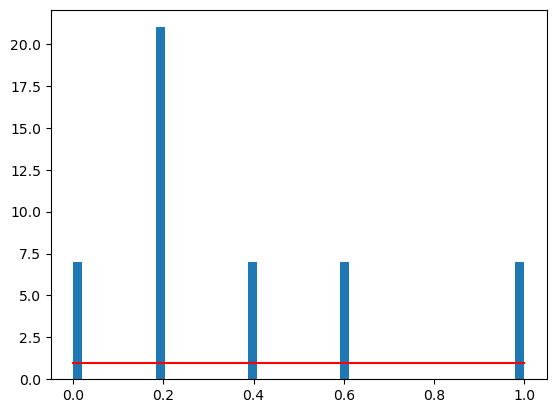

In [46]:
def Fibonacci(x0,x1,M):
    liste_fibo = [x0, x1]
    c = 0
    while c < 10 ** 4:
        c += 1
        suivant = liste_fibo[-1] + liste_fibo[-2]
        if suivant < M:
            liste_fibo.append(suivant)
        else:
            return liste_fibo
        
    return "Erreur dans la saisie des valeurs : il n'est pas possible d'obtenir une telle suite"

# test
X = Fibonacci(1783, 12, 10**4)
Y = [i / max(X) for i in X]  #pour avoir des nombres entre 0 et 1
plt.hist(Y, bins=np.linspace(0,1,50), density=True)
plt.plot([0,1],[1,1],'r')  #densité théorique
plt.show()

In [48]:
# Test LGN 
print(LGN(Y))  # 0.12872362350777616 > 0.05

# Test de Kolmogorov 
test_kolmogorov(Y, lambda x:x, 0.05) 

0.12872362350777616


"L'échantillon ne suit pas la loi de réfèrence"

## I-3 ) Générateur de nombres pseudos-aléatoires : Générateurs congruentiels linéaires

Introduits en 1948 par D. H. Lehmer sous une forme réduite (incrément nul), ils vont être généralisés et seront largement utilisés ensuite. Ils reposent sur une simple formule de récurrence :

$ x_{n+1} = a . x_n + c \space \space \text{mod} \space m \space$ avec $x_0$ la graine. 

Des théorèmes d'arithmétique donnent des formules pour $a,b,m$ et $x_{0}$ assurant  une bonne qualité pour le générateur. En particulier, ces générateurs sont cycliques et certains paramètres permettent d'obtenir un cycle très long. Nous admettons ces théorèmes et utilisons directement certains paramètres efficients. Par exemple, l'algorithme de Parker Miller utilise $x_{0} = 3, a = 69069, b= 0$  et $m = 2^{32}$.

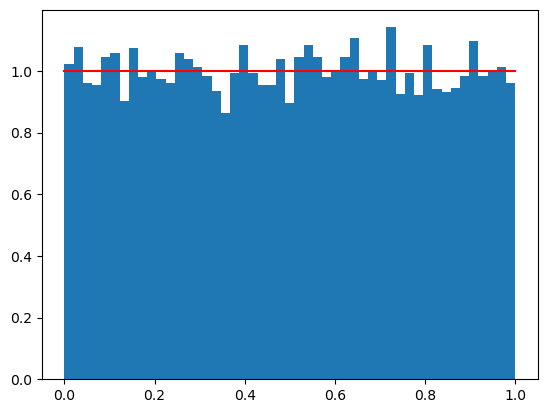

In [52]:
def f_pmiller(x, a = 69069, m = 2**32):
  return (a*x)% m

def parker_miller(n, x0 = 3, a = 69069, m = 2**32):
  X =[x0]
  for i in range(n): X.append(f_pmiller(X[-1]))
  return X

X = parker_miller(10**4)
Y = [i/max(X) for i in X]  #pour ramener sur l'intervalle [0;1]
plt.hist(Y, bins=np.linspace(0,1,50), density=True)
plt.plot([0,1],[1,1],'r')  #densité théorique
plt.show() 

In [55]:
# Test LGN 
print(LGN(Y))  # 0.0005399374236823573 < 0.05

# Présence de cycles ? 
print(Floyd(f_pmiller, 3))  # pas de cycle trouvé

# Test de Kolmogorov 
test_kolmogorov(Y, lambda x:x, 0.05)  #"L'échantillon ne suit pas la loi de réfèrence"

0.0005399374236823573
pas de cycle trouvé


"L'échantillon ne suit pas la loi de réfèrence"

## I-4 ) Générateur de nombres pseudos-aléatoires :  L'algorithme de Mersenne Twister

Cet algorithme fait partie de la famille des générateurs à congruence linéaire mixte. C'est un algorithme particulièrement performant, sa période est de $2^{19937}-1$ (le nombre de Mersenne à la puissance $199937$) et il est plus rapide que la plupart des générateurs. 

La fonction $rand()$ de Numpy.random génère une suite de nombres entre 0 et 1 avec l'algorithme de Mersenne Twister. Le choix de la graine au moment de l'éxecution se fait à partir du nombre de microsecondes de l'horloge de l'ordinateur. Ceci permet d'avoir de l'aléa dans le choix de la graine et ainsi, en lançant à deux instants différents la fonction, on obtient deux suites de nombres entre 0 et 1 indépendantes, donc deux variables aléatoires uniformes indépendantes.

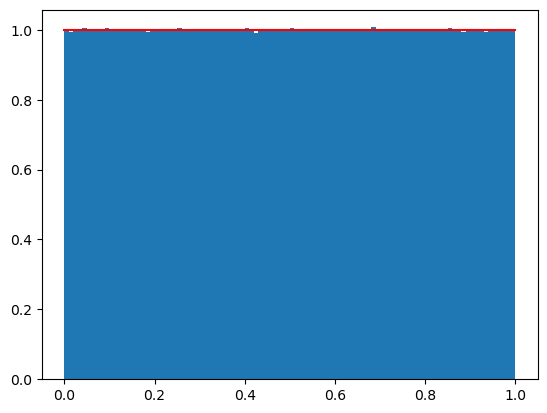

3.752916761878833e-05
pas de cycle trouvé


"L'échantillon ne suit pas la loi de réfèrence"

In [74]:
n=10**7
X=rand(n)
plt.hist(X, bins = np.linspace(0,1,101), density = True)  #densité empirique
plt.plot([0,1],[1,1],'r')  #densité théorique
plt.show()

print(LGN(X))  # 3.452974404660747e-05
print(Floyd(f_pmiller,3))  #pas de cycle trouvé
test_kolmogorov(X, lambda x:x,0.05)

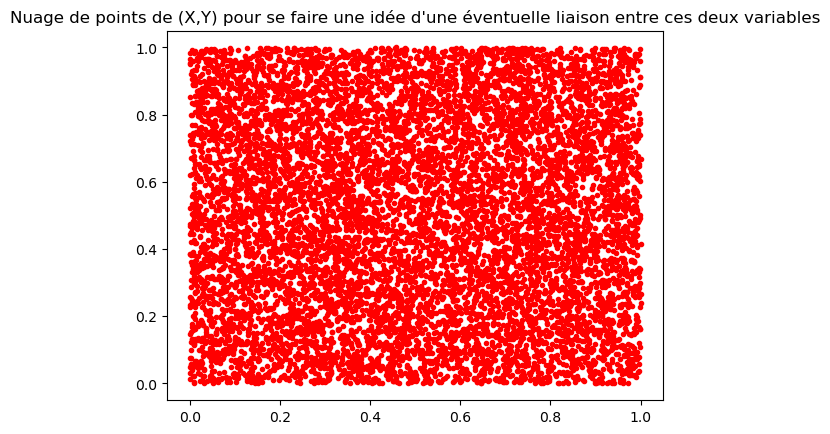


Conclusion:
Étant donnée la p-value, on peut affirmer que les variables sont independantes


In [67]:
#simulation de deux lois uniformes independantes

U = rand(10**4)
V = rand(10**4)

#indépendance
plt.plot(U,V,'r.')  #les variables semblent indépendantes étant donné le  nuage de points
plt.title("Nuage de points de (X,Y) pour se faire une idée d'une éventuelle liaison entre ces deux variables")
plt.show()

#test d'indépendance
# H0 : les variables sont indépendantes
print()
print("Conclusion:")
if stats.spearmanr(U, V).pvalue > 0.05:
  print("Étant donnée la p-value, on peut affirmer que les variables sont independantes")
else:
  print("Étant donnée la p-value, nous rejetons l'hypothèse d'independance des variables")

# **$\rm II)$  Simulation de variables aléatoires**

Simulons numériquement des variables aléatoires usuelles à partir des générateurs pseudo-aléatoires. 

Plusieurs méthodes démontrées mathématiquement nous garantissent que toutes les variables aléatoires réelles ou discrètes (à valeurs dans $\mathbb{N}$) peuvent être générées à partir d'une loi uniforme, d'où l'intérêt de la génération de nombres pseudo-aléatoires entre $0$ et $1$. 

Le meilleur générateur (en temps de calculs et en qualité de génération) parmi ceux étudiés dans la première partie est celui donné par la fonction *numpy.random.rand()* (basé sur l'**algorithme de Mersenne Twister**). 

Nous allons donc utiliser ce générateur pour simuler une loi uniforme sur $[0;1]$. De plus, cet algorithme permet d'obtenir des lois uniformes indépendantes, ceci est très utile pour la génération de certaines lois comme la loi gaussienne avec la méthode de Box Muller.

## II - a) Méthode d'inversion de la fonction de répartition

Soit $\mathbb{P}$ une probabilité sur $\mathbb{R}$ et $F$ la fonction de répartition associée. Pour tout $t \in ]0;1[$ on définit $F^{-}(t):= \inf \left\{ x \in \mathbb{R}, F(x)\geq t \right\}$ 


**Théorème:** 
Soit $U$ une variable aléatoire uniforme sur $[0;1]$, alors $F^{-}(U)$ suit la loi $\mathbb{P}$.

Ce résultat nous permet donc de simuler n'importe quelle variable aléatoire réelle (ou discrète puisque $\mathbb{N} \subset \mathbb{R}$) à partir d'une loi uniforme. Cependant, le calcul de $F^{-}$ peut s'avérer particulièrement compliqué. 

- $F^{-}$ est facilement calculable si $F$ est **strictement croissante** car dans ce cas $F$ est inversible et $F^{-}$ coïncide avec $F^{-1}$. 

- $F^{-}$ est également facile à calculer si la loi est discrète.

**Simulation de la loi exponentielle de paramètre $\lambda > 0$:**

La fonction de répartition d'une loi exponentielle est strictement croissante, on a donc une formule explicite pour $F^{-}$ donnée par $ x \mapsto -\frac{log(1-x)}{\lambda} $

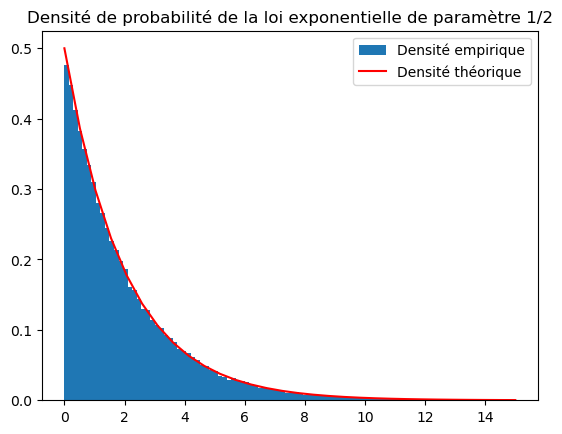

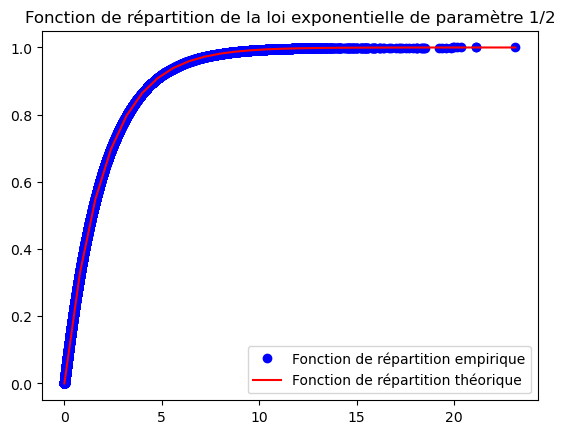

"l'échantillon ne suit pas la loi de réfèrence"

In [83]:
def simul_expo(lamb, n):    #lamb = paramètre ; n = nombre de simulations
    U = rand(n)
    return - np.log(1-U) / lamb

#simulation
n=10**5
xx = np.linspace(0,15,30)
X = simul_expo(0.5,n)   #exponentielle de paramètre 1/2
plt.hist(X, bins = np.linspace(0,15,101), density = True, label = 'Densité empirique')   #densité empirique
plt.plot(xx,0.5*np.exp(-0.5*xx) ,'r', label = 'Densité théorique')  #densité théorique
plt.title("Densité de probabilité de la loi exponentielle de paramètre 1/2")
plt.legend()
plt.show()


#fonction de répartition::
X = sorted(X)   #renvoie une liste triée, nécessaire pour tracer la fonction de répartition empirique
xx = np.linspace(0,max(X),30)
plt.plot(X,np.linspace(0,1,n),'bo', label = 'Fonction de répartition empirique')    #fonction de répartition empirique
plt.plot(xx,1-np.exp(-xx/2),'r', label = 'Fonction de répartition théorique')    #fonction de réparition théorique
plt.title("Fonction de répartition de la loi exponentielle de paramètre 1/2")
plt.legend()
plt.show()

#test de kolmogorov pour tester notre simulation:
test_kolmogorov(X,lambda x:1-np.exp(-0.5*x), 0.05)

**Simulation de la loi de Cauchy de paramètres $a> 0$ et $x_{0} \in \mathbb{R}$:**

Comme pour la loi exponentielle la fonction de répartition est strictement croissante, on a donc une formule explicite pour $F^{-}\space$,  $\space F^{-}: x \mapsto a \times tan(\pi(x-0.5)) +x_{0} $

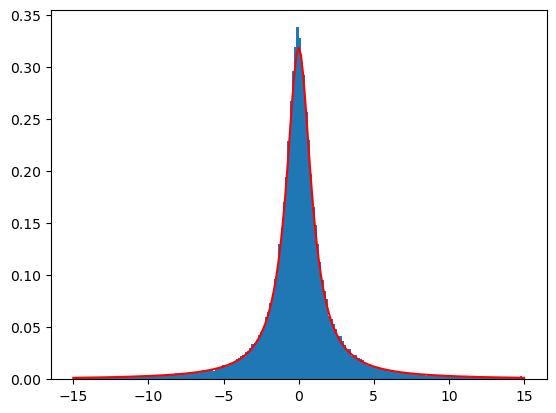

In [87]:
def simul_cauchy(a, x0, n): 
    U = rand(n)
    return a * np.tan( np.pi * (U - 0.5)) + x0

n=10**5
Y = simul_cauchy(1, 0, n) #a=1, x0= 0
xx = np.linspace(-15,15,201)
plt.hist(Y, bins=xx, density=True, label = 'Densité empirique');  #densité empirique
plt.plot(xx, (np.pi * (1 + xx ** 2)) ** (-1) ,'r', label = 'Densité théorique')  #densité théorique
plt.show()

In [90]:
#test de kolmogorov pour tester notre simulation:
test_kolmogorov(X,lambda x: 1 / 2 + np.arctan(x) / np.pi, 0.05)

"l'échantillon ne suit pas la loi de réfèrence"

Dans le **cas discret**, $F^{-}$ est aussi facile à calculer puisque la fontion de répartion $F$ est constante par morceaux et continue à droite : 
$ F = \sum_{i}  q_{i} \mathbb{1}_{[x_{i},x_{i+1}[}$  avec $q_{i} = \sum_{\mathbb{1} \leq j \leq i} p_{j} $. 

Les valeurs prises par $F^{-}$ sont donc $ \left\{x_{i}, i \in I\right\}$ avec $I$ dénombrable.
  

**Simulation d'une loi de Bernoulli de paramètre $p \in ]0;1[$:**

Pour une Bernoulli de paramètre $p$, on a:

Pour tout $\space t \leq p $, $F^{-}(t) = 0 \space $ et pour tout $ \space t \geq p $, $F^{-}(t) = 1$.

0.3977


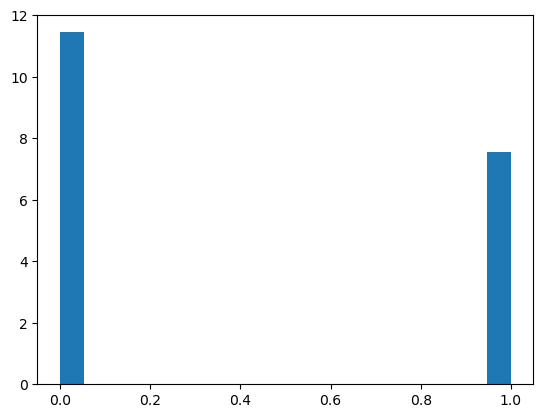

In [93]:
def simul_bernoulli(p,n):
  U = rand(n)
  X = 1 * (U<p)
  return X

#simulation
X = simul_bernoulli(0.4,10**4)  #p = 0.4
plt.hist(X, bins = np.linspace(0,1,20), density = True); 
print(np.mean(X))   #on vérifie que l'espérance est bien de 0.4 (0.3977)

**Simulation d'une loi de Poisson de paramètre $\lambda >0$:**

Dans un premier temps, nous allons calculer $F$ puis déduire $F^{-}$ à partir de $F$. 

Comme une loi de Poisson donne une masse strictement positive à tout $n$ entier naturel, nous ne pouvons pas contruire $F$ complètement. Cependant, l'inégalité de Markov nous assure que $ \mathbb{P}(X> 10 \lambda) < 1/10 $. 

La probabilité d'être dix fois supérieure à $\lambda$ est inférieure à 0.1, nous choississons donc de ne construire $F$ que sur $\left\{0,...,10\lambda \right\}$.

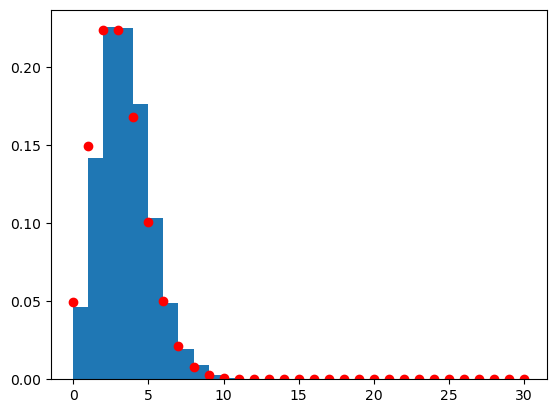

In [103]:
def simul_poisson(lamb, n):
    X = np.zeros(n)
    sample = 10 * lamb

    #Fonction de masse 
    T = np.zeros(sample)
    for i in range(sample):
        T[i] = (np.exp(-lamb) * lamb ** i) / factorial(i)
    #Somme cumulée de la fonction de masse
    C = np.cumsum(T)
    np.append(C,1)

    for i in range(n): X[i] = np.where(rand() < C)[0][0]
    return X

l=3
X = simul_poisson(l,10**4)
xx = np.linspace(0,10*l,10*l+1)
plt.hist(X, bins=xx, density = True)    #fonction de masse empirique
plt.plot(xx, (np.exp(-l)*l**xx)/factorial(xx), 'ro')    #fonction de masse théorique

**Simulation d'une loi binomiale de paramètre $p \in ]0;1[$ et $m \in \mathbb{N}$:**

On utilise le fait qu'une loi binomiale de paramètre $(m,p)$ est égale en distribution à la somme de $m$ variables de Bernoulli de paramètre $p$ indépendantes. La fonction $rand()$ nous permet de générer des variables uniformes indépendantes,  nous pouvons donc également générer des variables de Bernoulli indépendantes.

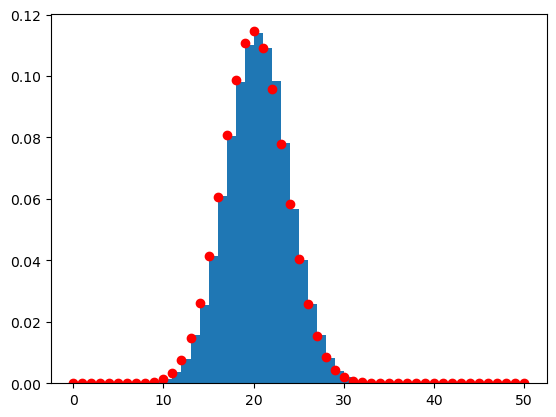

In [104]:
def simul_binomiale(m,p,n):
  M = np.zeros((m,n))

  for i in range(m):
    M[i,:] = simul_bernoulli(p,n)

  return np.sum(M,axis=0) #on somme les Bernoulli indépendantes  pour obtenir des Binomiales

m = 50
p = 0.4
n = 10**5

X = simul_binomiale(m,p,n)
xx = np.linspace(0,m,m+1)
plt.hist(X, bins=xx, density=True)  #fonction de masse empirique
plt.plot(xx, factorial(m)/(factorial(xx)*factorial(m-xx))*p**xx*(1-p)**(m-xx),'ro') #fonction de masse théorique

## II - b) Méthode du rejet

La méthode du rejet permet de simuler des lois admettant une densité par rapport à la mesure de Lebesgue. Cette méthode nécessite également de disposer d'une loi auxiliaire admettant aussi une densité par rapport à la mesure de Lebesgue et qui vérifie certaines propriètés vis à vis de notre loi d'intérêt.
L'idée est qu'on sait simuler facilement la loi auxiliaire et on se sert de cette loi pour simuler notre loi d'intérêt.  

Formellement, supposons qu'on souhaite générer une variable $X$ de loi $\mathbb{P}$ admettant une densité $f$ par rapport à la mesure de Lebesgue et que l'on dispose d'une variable $Y$ de loi $\mathbb{Q}$ aussi continue par rapport à la mesure de Lebesgue, de densite $g$ telle que $\frac{f}{g}$ soit bornée par une constante $c$  ($*$). 

On pose $ \rho = \frac{f}{g}$. 

Soient $(U_{k})_{k}$ une suite de variables i.i.d. uniformes  sur $[0;1]$ et $(V_{k})_{k}$ une suite de variables i.i.d. de loi $\mathbb{Q}$.

Alors, $K:= \inf \left\{ k \geq 1, U_{k} \leq \frac{\rho(V_{k})}{c} \right\}$ suit une loi géométrique de paramètre $\frac{1}{c}$ et $V_{K}$ suit la loi $\mathbb{P}$ (la loi que l'on souhaite simuler).



In [116]:
def simul_rejet(p, simu, n):
    X = np.zeros(n)
    c = - optimize.fmin( lambda x : -p(x), 0, full_output = True)[1]
    for i in range(n): 
        U, Y = 2, 0
        while U > p(Y) / c : 
            U = rand()
            Y = simu(1)
        
        X[i] = Y
    
    return X

**Simulation d'une loi gaussienne à partir d'une loi de Cauchy avec la méthode du rejet:**

Nous savons simulé une loi de Cauchy grâce à la méthode d'inversion de la fonction de répartiton. La méthode d'inversion de la fonction de répartition est difficilement applicable à une loi gaussienne puisque l'on ne dispose pas de formule explicite pour la fonction de répartition d'une gaussienne. 

Toutefois, la loi gaussienne et la la loi de Cauchy admettent une densité par rapport à la mesure de Lebesgue et ces densités verifient la propriété. On peut donc simuler une variable gaussienne à l'aide d'une variable de loi de Cauchy :

Optimization terminated successfully.
         Current function value: -1.520347
         Iterations: 25
         Function evaluations: 50


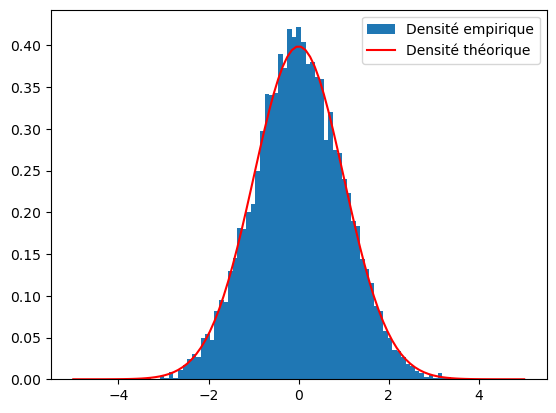

"l'échantillon ne suit pas la loi de réfèrence"

In [117]:
def p(x):   #p = f/g, le rapport des densités
  f = ( 1 / np.sqrt( 2 * np.pi) ) * np.exp( - 0.5 * (x) ** 2 )
  g = 1 / ( np.pi * (1 + x**2 ))
  return f / g  #rapport des densités

def simul_gaussienne(n): #la fonction de simulation de la loi auxiliaire, ici une loi de Cauchy(a=1,xo=0)
  return simul_cauchy(1, 0, n)


xx = np.linspace(-5,5,100)
X = simul_rejet(p, simul_gaussienne, 10 ** 4)
plt.hist(X, bins=xx, density=True, label = 'Densité empirique') #densité empirique
plt.plot(xx,(1 / np.sqrt(2*np.pi) ) * np.exp( - 0.5 * (xx) **2 ),'r', label = 'Densité théorique') #densité théorique
plt.legend()
plt.show()

#test, on utilise scipy car on a pas de formule explicite pour la fdr d'une loi normale
from scipy.stats import norm
test_kolmogorov(X, lambda x:norm.cdf(x), 0.05)

L'algorithme de rejet implémenté ne possède pas un nombre maximal d'itérations. Si l'on note $N$ le nombre d'itérations, $N$ suit une loi géométrique de paramètre $\frac{1}{c}$ car la probabilité de rejeter $V_{k}$ vaut $c$. Il faut donc choisir $c$ le plus petit possible pour avoir le moins d'itérations et donc un algorithme performant. Il faut donc chercher une loi auxiliaire dont la densité $g$ est "proche" de $f$.

Optimization terminated successfully.
         Current function value: -1.520347
         Iterations: 25
         Function evaluations: 50
1.5203469010662807
Optimization terminated successfully.
         Current function value: -5.708680
         Iterations: 22
         Function evaluations: 44
5.708680136706425


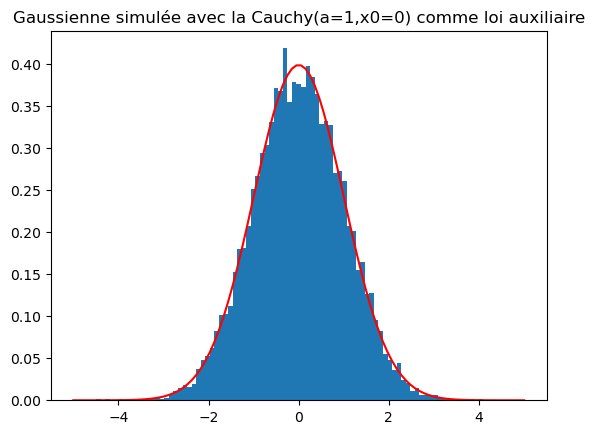

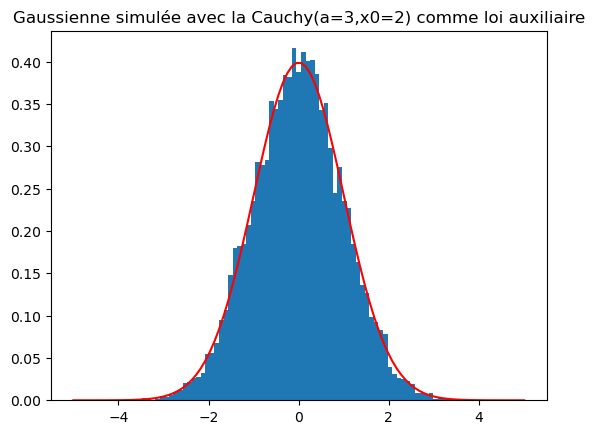

nombre d'itérations Cauchy(a=1,x0=0):  15213
nombre d'itérations Cauchy(a=3,x0=2):  57000


In [118]:
#même fonction mais qui renvoie en plus le nombre d'itérations

def simul_rejet_iter(p,simu,n):
  cpt= 0 # compteur du nombre d'itérations
  X = np.zeros(n)
  c = -optimize.fmin(lambda x: -p(x), 0, full_output=True)[1]
  print(c)

  for i in range(n):
    U = 2
    Y = 0
    while U > p(Y)/c:
        cpt+=1
        U = rand()
        Y = simu(1)
    X[i] = Y
  return X,cpt


#avec la Cauchy(a=1,x0=0)
def p(x):
  return ((1/np.sqrt(2*np.pi))*np.exp(-0.5*(x)**2)) / (1/(np.pi*(1+x**2)))
def simu_gaussienne(n):
  return simul_cauchy(1,0,n)

#avec la Cauchy(a=3,x0=2)
def p2(x):
  return ((1/np.sqrt(2*np.pi))*np.exp(-0.5*(x)**2)) / (1/(3*np.pi*(1+((x-2)/3)**2)))
def simu_gaussienne2(n):
  return simul_cauchy(3,2,n)


X, c1 = simul_rejet_iter(p,simu_gaussienne,10**4)
Y , c2 = simul_rejet_iter(p2,simu_gaussienne2,10**4)

plt.hist(X,bins=xx,density=True)
plt.plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
plt.title("Gaussienne simulée avec la Cauchy(a=1,x0=0) comme loi auxiliaire")
plt.show()

plt.hist(Y,bins=xx,density=True)
plt.plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')
plt.title("Gaussienne simulée avec la Cauchy(a=3,x0=2) comme loi auxiliaire")
plt.show()

print("nombre d'itérations Cauchy(a=1,x0=0): ",c1)
print("nombre d'itérations Cauchy(a=3,x0=2): ",c2)

**Simulation d'une loi Bêta à partir d'une loi uniforme avec la méthode du rejet:**

Comme dans le cas précèdent, la loi Bêta et la loi uniforme (toutes deux ayant comme support $[0;1]$) vérifient la proprièté $(*)$, on peut donc utiliser l'algorithme de rejet pour simuler une loi Bêta à partir d'une loi uniforme.

  
La loi Bêta de paramètres $a,b \in \mathbb{R}^{+*}$ admet comme densité $f: x \mapsto \frac{\gamma(a+b)}{\gamma(a)\gamma(b)}x^{a-1}(1-x)^{b-1}\mathbb{1}_{[0;1]}(x)$ .

Optimization terminated successfully.
         Current function value: -2.109375
         Iterations: 24
         Function evaluations: 48


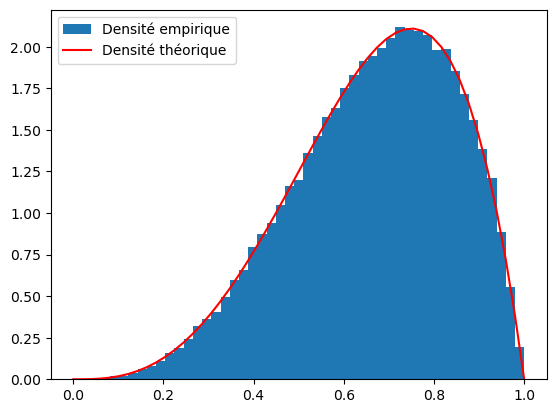

In [122]:
a , b = 4 , 2

def p_bis(x): # p = rapport des densités (comme précedemment)
  return (mat.gamma(a+b)/(mat.gamma(a)*mat.gamma(b)))*x**(a-1)*(1-x)**(b-1)

def simu_beta(n): #simulation de la loi auxiliaire: la loi uniforme
  return rand(n)

xx = np.linspace(0,1,50)
X = simul_rejet(p_bis, simu_beta, 10**5)
plt.hist(X, bins=xx, density=True, label = 'Densité empirique') 
plt.plot(xx,(mat.gamma(a+b)/(mat.gamma(a)*mat.gamma(b)))*xx**(a-1)*(1-xx)**(b-1),'r', label = 'Densité théorique') 
plt.legend()
plt.show()

## II - c) Méthode du changement de variable

Enfin, nous implémentons quelques méthodes de simulation basées sur des changements de variables. Supposons que l'on veuille simuler une variable aléatoire de loi $\mathbb{P}$ et que l'on sache simuler une variable aléatoire $X$. L'idée est de trouver un changement de variable adéquat $\phi$ tel que $\phi(X)$ suit la loi $\mathbb{P}$. 

Biensûr, de tels changements de variables ne sont pas toujours possibles; nous allons impleménté quelques changements de variables connus. 

L'avantage de ces méthodes est que chaque variable suivant la loi auxilaire est utilisée contrairement à la méthode du rejet où seulement une partie des variables est utilisée dans la géneration. Les changements de variables sont donc moins coûteux en termes d'itérations.

**Le changement de variable de Box Muller**

Soient $(U_{k})_{k}$ et  $(V_{k})_{k}$ deux suites de variables iid indépendantes de lois uniformes sur $[0;1]$. 

Alors, les variables $X_{k}:=\sqrt{-2\log(U_{k})}cos(2\Pi V_{k})$ et $Y_{k}:=\sqrt{-2\log(U_{k})}sin(2\Pi V_{k})$ sont indépendantes et suivent une loi normale centrée réduite.

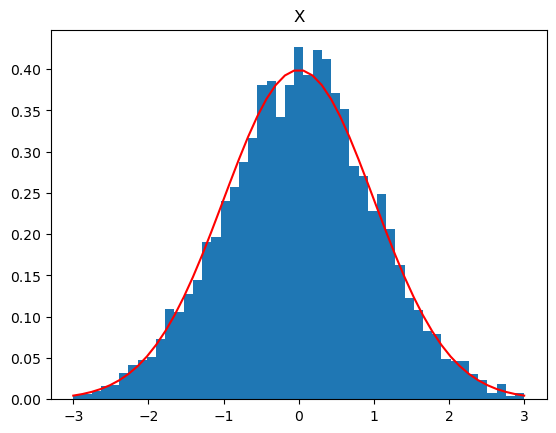

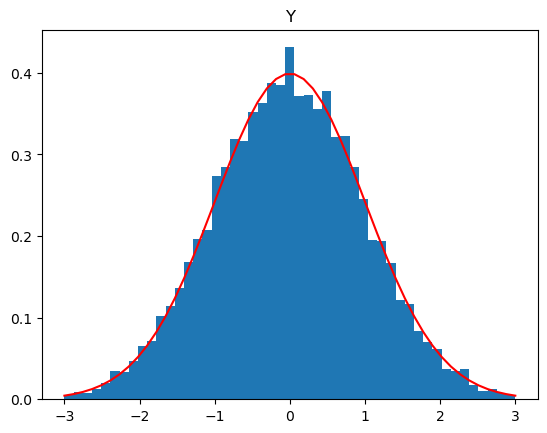

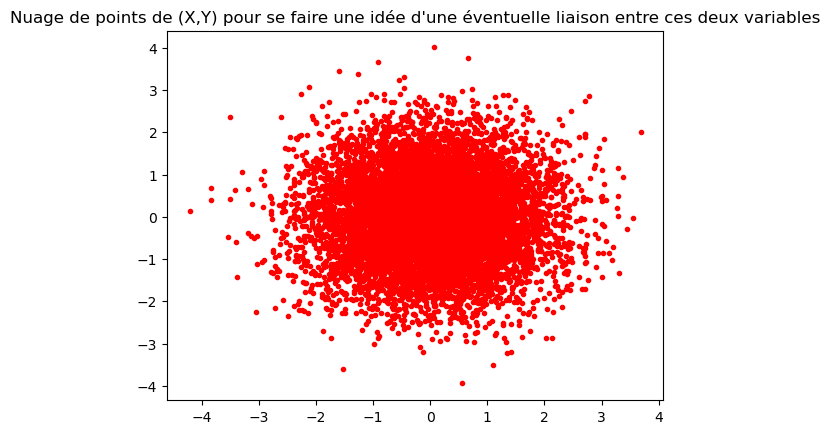


Conclusion:
etant donnée la p-value, on peut affirmer que les variables sont independantes


In [125]:
def Box_Muller(n):
    U = rand(n)
    V = rand(n)
    X = np.sqrt(- 2 * np.log(U)) * np.cos(2* np.pi * V)
    Y = np.sqrt(- 2 * np.log(U)) * np.sin(2* np.pi * V)
    return X, Y

   
n = 10**4
X,Y = Box_Muller(n)

xx = np.linspace(-3,3,50)
plt.hist(X, bins=xx, density=True)
plt.plot(xx,(1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (xx) ** 2),'r')
plt.title("X")
plt.show()

plt.hist(Y,bins=xx,density=True)
plt.plot(xx,(1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * (xx) ** 2),'r')
plt.title("Y")
plt.show()

#indépendance
plt.plot(X,Y,'r.')  #les variables semblent indépendantes étant donné le  nuage de points
plt.title("Nuage de points de (X,Y) pour se faire une idée d'une éventuelle liaison entre ces deux variables")
plt.show()


#test d'indépendance
# H0 : les variables sont indépendantes
print()
print("Conclusion:")
if stats.spearmanr(X, Y).pvalue > 0.05:
  print("etant donnée la p-value, on peut affirmer que les variables sont independantes")
else:
  print("etant donnée la p-value, nous rejetons l'hypothèse d'independance des variables")

**Changement de variable pour la loi Bêta**  

Si $U$ suit une loi uniforme sur $[0;1] \space $, $ \space sin^{2}(\pi \frac{U}{2}) \space$ suit la loi Bêta de paramètres 1/2 et 1/2.

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_3052/1380771865.py:11: RuntimeWarning: divide by zero encountered in power
  plt.plot(xx, (mat.gamma(a+b) / (mat.gamma(a) * mat.gamma(b))) * xx **(a-1) * (1-xx) ** (b-1), 'r')


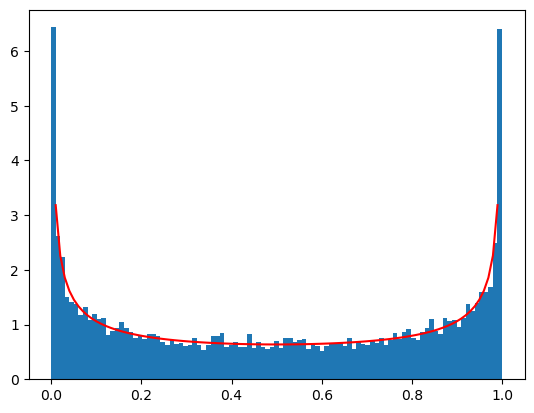

In [126]:
def simul_beta2(n):
    U = rand(n)
    return (np.sin(np.pi * (U / 2))) ** 2

n = 10 ** 4
a, b = 0.5, 0.5 
xx = np.linspace(0,1,100)
X = simul_beta2(n)

plt.hist(X, bins = xx, density = True)
plt.plot(xx, (mat.gamma(a+b) / (mat.gamma(a) * mat.gamma(b))) * xx **(a-1) * (1-xx) ** (b-1), 'r')

## II -d) Simulation de lois Gaussiennes avec le Théorème Central Limite (TCL)

Soit $(U_{k})_{k}$ une suite de variables aléatoires iid admettant un moment d'ordre 2. Notons $m$ leur espérance et $\sigma$  leur variance. 

Le Théorème Central Limite nous assure que $\frac{\sqrt{n}}{\sigma} \times (\frac{1}{n}\sum_{i=1}^n U_{i} -m)$ converge en loi vers une variable normale centrée réduite lorsque $n \rightarrow +\infty$ .

Soit $(U_{k})_{k}$ une suite iid de variables uniformes sur $[0;1]$ :

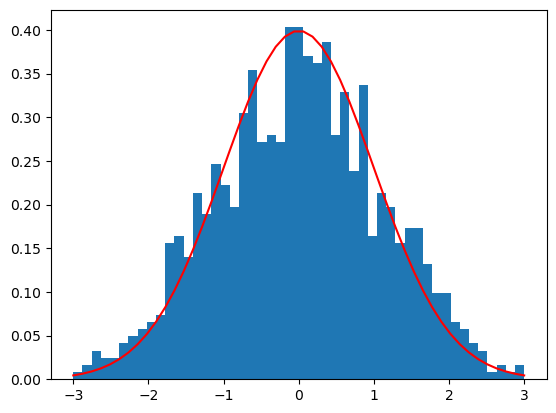

In [132]:
n = 10**4   #nombre de simulations de variables gaussiennes
k = 10**3   #nombre d'uniformes pour générer chaque gaussienne, on considère être dans l'asymptotique à 10**3.


U = np.zeros((k,n))
for i in range(k):
  U[i,:] = rand(n)

sig = 1 / 12
m = 1 / 2

X =  ( np.sqrt(k) / sig ) * (np.mean(U,axis=1) - m)   #on applique la formule du TCL aux n vecteurs de taille k contenant des uniformes iid.
xx = np.linspace(-3,3,50)
plt.hist(X,bins=xx,density=True)
plt.plot(xx,(1/np.sqrt(2*np.pi))*np.exp(-0.5*(xx)**2),'r')

# **$\rm III)$ Applications : les méthodes de Monte Carlo**

##  III - a) Introduction avec le calcul approché de $\pi$

L'aire du disque de rayon $1$ est $\pi$. 

L'aire d'un carré de coté de longueur $2$ centré en $(0,0)$ est $4$. 

Si l'on simule une loi uniforme sur ce carré, la probabilité $p$ de se trouver dans le disque est le rapport entre les deux aires soit  $\frac{\pi}{4}$. Ainsi $\pi = 4p$. Cette formule nous donne une méthode pour obtenir une valeur approchée de $\pi$ :

*   A l'aide deux variables uniformes indépendates sur $[-1;1]$, on génère une loi uniforme sur $[-1;1]^{2}$.
*   On approxime $p$ en calculant le rapport entre le nombre de réalisations dans le disque unité et le nombre total de réalisations.
* Une fois $p$ approximée, on approxime $\pi = 4p$ .

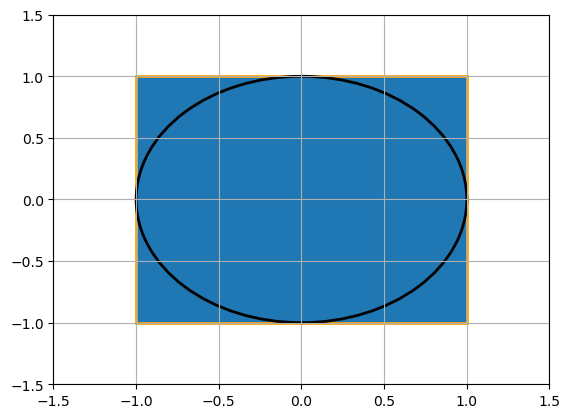

In [7]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
square = patches.Rectangle((-1, -1), 2, 2, linewidth=2, edgecolor='orange')
ax.add_patch(square)
circle = patches.Circle((0, 0), radius=1, linewidth=2, edgecolor='black')
ax.add_patch(circle)
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.show()

In [11]:
# Loi uniforme sur [0,1]x[0,1]
n = 10 ** 6
U = rand(n)
V = rand(n)

# Approximation de la probabilité p 
pi_approx = 4 * ( len( U[U**2 + V**2 < 1] ) / 10**6 ) 

print("Approximation de pi : ", pi_approx, "\nVraie valeur de pi : ", np.pi)

Approximation de pi :  3.14214 
Vraie valeur de pi :  3.141592653589793


In [4]:
pi_approx = []
for i in range(10 ** 6):
    n = i
    U = rand(i)
    V = rand(i)
    pi_approx.append(4 * ( len( U[U**2 + V**2 < 1] ) / 10**6 ))

plt.figure(figsize=(12,8))
plt.plot(list(range(10 ** 6)), pi_approx, label = 'Approximation de pi', color = 'blue')
plt.axhline(y=np.pi, color='r', linestyle='--', label='Vraie valeur de pi')
plt.legend()
plt.show()

KeyboardInterrupt: 

## II - b) Calcul intégral numérique en dimension 1

### Monte Carlo sur un segment de $\mathbb{R}$

Soit $f$ une fonction d'une variable réelle à valeurs réelles, intégrable sur $\mathbb{R}$. 

On souhaite calculer $I(f) : = \int_{\mathbb{R}} f$.   


Soit $X$ une variable aléatoire réelle de loi $\mathbb{P}_{X}$ et $g$ une fonction d'une variable réelle à valeurs réelles telle que $E[|g(X)|]$ existe. 

Le théorème de transfert nous permet d'affirmer que $E[g(X)] = \int_{\mathbb{R}} g(x) d\mathbb{P}_{X}(x)$. De plus, si $X$ admet une densité $f_{X}$ par rapport à la mesure de Lebesgue, $E[g(X)] = \int_{\mathbb{R}} g(x) \times f_{X}(x) dx $.  

Le principe de la **méthode de Monte Carlo** est de trouver une variable aléatoire $X$ et une fonction $g$ (avec $E[|g(X)|] < +∞$)  telles  que $E[g(X)] = I(f)$.

Etant donné que $E[|g(X)|] < +∞$, la loi forte des Grands nombres s'applique: 
soient $(X_{k})_{k}$ une suite  de variables *iid* de loi $\mathbb{P}_{X}$, $\frac{1}{n}\sum_{i}^{n} g(X_{i})$ converge presque sûrement vers $E[g(X)]=I(f)$. On a donc un estimateur convergeant et sans biais de $I(f).$

  
De plus, il est possible de construire un intervalle de confiance asymptotique de $I(f)$ avec le **Théorème Central Limite**: 

$ \mathbb{P}( \space I(f) \in [G_{n} - c\sqrt{\frac{Var(g(X))}{n}} ; G_{n} + c\sqrt{\frac{Var(g(X)}{n}} ] \space ) \space $ $ \space \xrightarrow{d} \space $ $ \space \int_{[-c;c]}\frac{1}{\sqrt{2 \pi}} e^{-\frac{x^{2}}{2}} \space dx $.  


Pour $c=2.6$ , $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx >0.99$. 

Il est donc possible d'obtenir un encadrement très précis avec une probabilité élevée de $I(f)$ pour $n$ grand. Cependant, ceci nécessite de connaître $Var(g(X))$, on l'estime à l'aide de : $\sigma_{n}^{2} := \frac{1}{n} \sum_{i}^{n}g(X_{i})^{2} - G_{n}^{2}$ .  
  
Finalement, $\mathbb{P}(|G_{n} - I(f)|< c\frac{\sqrt{\sigma_{n}^{2}}}{\sqrt{n}})$ $→$ $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx$. En d'autres termes, notons $e_{n}$ l'erreur, $e_{n} := |G_{n} - I(f)|$; avec une probabilité $1-\alpha$,  $|e_{n}|<q_{1-\frac{\alpha}{2}}\frac{\sqrt{\sigma_{n}^{2}}}{\sqrt{n}}$ où $q_{1-\frac{\alpha}{2}}$ désigne le quantile d'ordre $1-\alpha$ de la loi normale centrée réduite.

Nous commençons par définir une fonction *MC1* qui permet d'approximer avec la méthode de Monte Carlo $\int_{[a;b]} f(x) dx$. En effet, dans le cas où $f$ est à support compact $[a,b]$, en prenant $X$ une variable aléatoire de loi uniforme sur $[a;b]$ et $g=(b-a)f$ on a $I(f)= E[g(X)]$. Il est donc toujours possible d'approximer $I(f)$ avec les méthodes de Monte Carlo lorsque f est à support compact.

In [3]:
def MC1(f,a,b,n):
    U = (b - a) * rand(n) + a   #loi uniforme sur [a,b]
    Y = f(U)
    return ((b - a) / n ) * sum(Y) 

MC1(lambda x:x ** 2, 0, 3, 10 ** 5)

9.003081910744317

**Nous allons à présent illuster numériquement les propriètés asymptotiques de la méthode de Monte Carlo.** 



Dans un premier temps, nous calculons la probabilité asymptotique que l'intervalle de confiance $[G_{n} - c\sqrt{\frac{Var(g(X))}{n}} ; G_{n} + c\sqrt{\frac{Var(g(X)}{n}} ]$ contienne $I(f)$. Cette probabilité doit être proche de $\int_{[-c;c]}\frac{e^{-\frac{x^{2}}{2}}}{\sqrt{2\Pi}}dx$.

Nous considérons que $10^{4}$ est asymptotique est nous prenons $c=1.645$, le quantile d'odre $0.05$ de la loi normale centré réduite. En théorie, nous devons obtenir une probabilité proche de $0.9= 1-2\times 0.05.$

$\sigma_{n}^{2} := \frac{1}{n} \sum_{i}^{n}g(X_{i})^{2} - G_{n}^{2}$

Probabilité théorique = 0.9 probabilité empirique: 0.897


/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_985/381218075.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot((binf[i],bsup[i]), (xx[i],xx[i]),'b-', color = 'green')
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_985/381218075.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot((9,9), (xx[0], xx[-1]), 'k-', color = 'red', label = 'Vraie valeur')


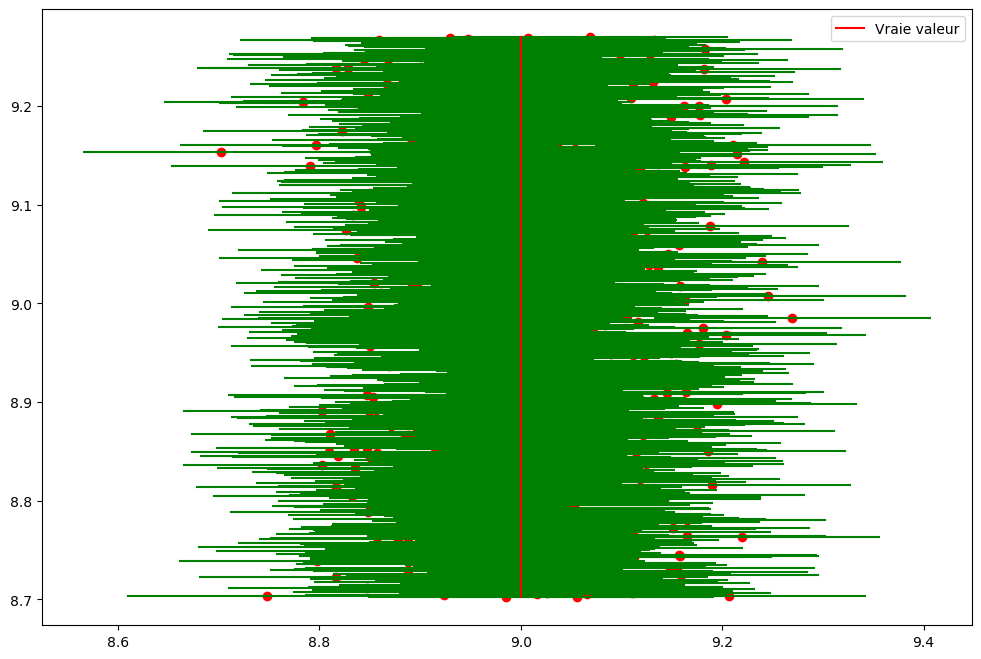

In [9]:
def intervalle_TCL(n, f, I, a, b, c):  # I = I(f), n = nombre d'approximations calculées
    cpt = 0     #on compte le nombre de fois où I(f) est effectivement dans l'intervalle de confiance (IC)
    approx = [] #liste des valeurs approximées
    bsup = []   #liste des bornes sup des intervalles de confiance
    binf =[]    #liste des bornes inf des intervalles de confiance
    for i in range(n):
        Gn = MC1(f, a, b, 10 ** 4)
        sigma_2 = MC1(lambda x:f(x)**2, a, b, 10**4)
        approx.append(Gn)
        bsup.append(Gn + c * np.sqrt(sigma_2 / 10 ** 4))
        binf.append(Gn - c * np.sqrt(sigma_2 / 10 ** 4))
        if I < Gn + c*np.sqrt(sigma_2 / 10**4) and I > Gn - c * np.sqrt(sigma_2 / 10**4):
            cpt += 1
    return approx, cpt / n , bsup, binf


resultats = intervalle_TCL(10 ** 3, lambda x : x ** 2, MC1(lambda x : x ** 2, 0, 3, 10 ** 4), 0, 3, 1.96)
print("Probabilité théorique = 0.9", "probabilité empirique:" ,resultats[1])  #on a pris le quantile d'ordre 0.05, la probabilité théorique est donc 1-2*0.05 = 0.9


plt.figure(figsize=(12,8))
val = resultats[0]  #valeurs d'approximation fournies par Monte Carlo
xx = np.linspace(min(val), max(val), len(val))  #les valeurs obtenues sont en abscisse
plt.plot(val,xx,'ro')

#bornes des IC:
bsup = resultats[2]
binf = resultats[3]

#autour de chaque valeur approchée, on trace l'intervalle de confiance associé
for i in range(len(binf)):
  plt.plot((binf[i],bsup[i]), (xx[i],xx[i]),'b-', color = 'green')

#vraie valeur : 9, on voit ainsi si un intervalle de confiance contient ou non la vraie valeur.
plt.plot((9,9), (xx[0], xx[-1]), 'k-', color = 'red', label = 'Vraie valeur')
plt.legend()
plt.show()